In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
os.chdir("..") 
print("CWD:", os.getcwd()) 

CWD: /Users/oliver/Desktop/BitcoinGraphClassification


In [2]:
import src.data_loader
print(dir(src.data_loader))

['Data', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'load_wallet_graph_combined', 'np', 'os', 'pd', 'torch']


In [3]:
print(os.listdir("data/raw"))

['.DS_Store', 'AddrAddr_edgelist.csv', 'wallets_features_classes_combined.csv']


In [4]:
from src.data_loader import load_wallet_graph_combined
import torch

data = load_wallet_graph_combined("data/raw")

print(data)
print("Feature shape:", data.x.shape)
print("Label counts:", torch.bincount(data.y[data.y >= 0]))


Data(x=[1268260, 56], edge_index=[2, 2868963], y=[1268260])
Feature shape: torch.Size([1268260, 56])
Label counts: tensor([338871,  28601])


In [5]:
from src.gcn import GCN

model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2)
print(model)

out = model(data.x, data.edge_index)
print("Output shape:", out.shape)


GCN(
  (conv1): GCNConv(56, 64)
  (conv2): GCNConv(64, 2)
)
Output shape: torch.Size([1268260, 2])


In [6]:
data = load_wallet_graph_combined("data/raw")
print("Label counts:", torch.bincount(data.y[data.y >= 0]))


Label counts: tensor([338871,  28601])


In [7]:
import pandas as pd
df = pd.read_csv("data/raw/wallets_features_classes_combined.csv")
print(df['class'].value_counts())
data.y.dtype == torch.long

class
3    900788
2    338871
1     28601
Name: count, dtype: int64


True

In [ ]:
import random
import pandas as pd
import numpy as np
import torch
from src.gcn import GCN
from src.graphsage import GraphSAGE
from src.train import train, evaluate
from src.utils import FocalLoss  

def set_seed(seed=420):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Compute class weights from label distribution
label_counts = torch.bincount(data.y[data.y >= 0])
class_weights = 1.0 / label_counts.float()
class_weights = class_weights / class_weights.sum()  # normalite

results = {}

# Split known labels into train/val sets
labeled_nodes = (data.y >= 0).nonzero(as_tuple=False).view(-1)
num_labeled = len(labeled_nodes)

perm = torch.randperm(num_labeled)
num_train = int(0.8 * num_labeled)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[labeled_nodes[perm[:num_train]]] = True
val_mask[labeled_nodes[perm[num_train:]]] = True

for model_name, Model in {"GCN": GCN, "GraphSAGE": GraphSAGE}.items():
    print(f"\nTraining {model_name}")

    if model_name == "GraphSAGE":
        model = Model(
            in_channels=data.x.shape[1],
            hidden_channels=128,
            out_channels=2,
            num_layers=3,
            dropout=0.4
        ).to(device)
        max_epochs = 100
    else:
        model = Model(
            in_channels=data.x.shape[1],
            hidden_channels=64,
            out_channels=2
        ).to(device)
        max_epochs = 30  # Early stop for GCN

    # for now i use CrossEntropyLoss for both models
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

    log = {"epoch": [], "loss": [], "acc": [], "f1": []}

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, train_mask, criterion)
        acc, f1, pr_auc = evaluate(model, data, val_mask)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | PR-AUC: {pr_auc:.4f}")

        log["epoch"].append(epoch)
        log["loss"].append(loss)
        log["acc"].append(acc)
        log["f1"].append(f1)

    results[model_name] = pd.DataFrame(log)
    results[model_name].to_csv(f"results/results_{model_name}.csv", index=False)



Training GCN
Epoch 001 | Loss: 100391.2891 | Acc: 0.9243 | F1: 0.4803 | PR-AUC: 0.0757
Epoch 002 | Loss: 80832.8516 | Acc: 0.6400 | F1: 0.4103 | PR-AUC: 0.0706
Epoch 003 | Loss: 66049.0547 | Acc: 0.4930 | F1: 0.3607 | PR-AUC: 0.0669
Epoch 004 | Loss: 60295.1641 | Acc: 0.2876 | F1: 0.2686 | PR-AUC: 0.0817
Epoch 005 | Loss: 59299.7930 | Acc: 0.2569 | F1: 0.2451 | PR-AUC: 0.0816
Epoch 006 | Loss: 60449.4023 | Acc: 0.2422 | F1: 0.2331 | PR-AUC: 0.0810
Epoch 007 | Loss: 57084.7305 | Acc: 0.2362 | F1: 0.2284 | PR-AUC: 0.0817
Epoch 008 | Loss: 56345.2734 | Acc: 0.2369 | F1: 0.2290 | PR-AUC: 0.0818
Epoch 009 | Loss: 53291.8359 | Acc: 0.2508 | F1: 0.2407 | PR-AUC: 0.0829
Epoch 010 | Loss: 50145.4062 | Acc: 0.3251 | F1: 0.2989 | PR-AUC: 0.0882
Epoch 011 | Loss: 46321.5820 | Acc: 0.4345 | F1: 0.3752 | PR-AUC: 0.0982
Epoch 012 | Loss: 42491.6875 | Acc: 0.7442 | F1: 0.5643 | PR-AUC: 0.1461
Epoch 013 | Loss: 41047.7891 | Acc: 0.7878 | F1: 0.5870 | PR-AUC: 0.1497
Epoch 014 | Loss: 39478.6562 | Acc: 

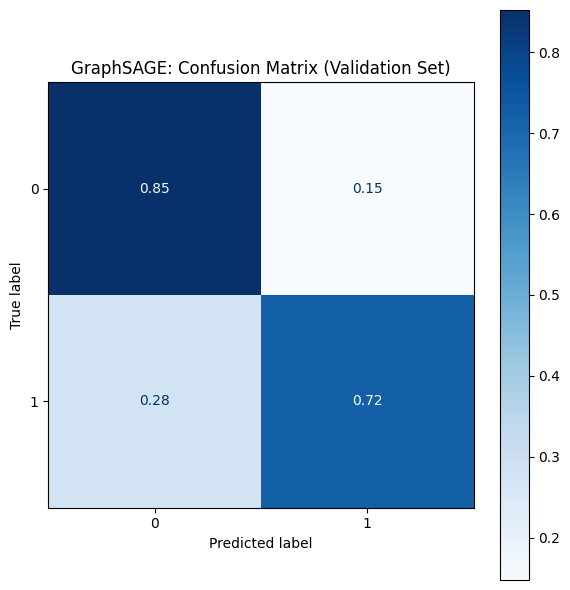

In [12]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get model predictions on the validation set
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    preds = out[val_mask].argmax(dim=1).cpu().numpy()
    true = data.y[val_mask].cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(true, preds, normalize='true')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("GraphSAGE: Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


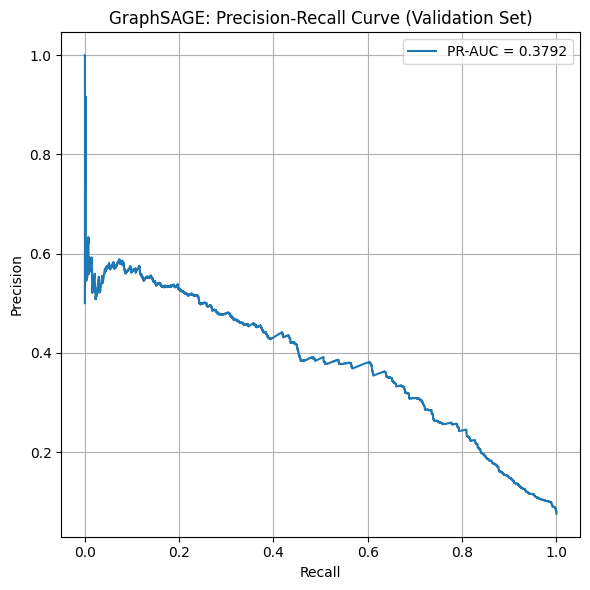

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure your model is in eval mode and on correct device
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    prob = torch.softmax(out[val_mask], dim=1)[:, 1].cpu().numpy()
    true = data.y[val_mask].cpu().numpy()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(true, prob)
pr_auc = average_precision_score(true, prob)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("GraphSAGE: Precision-Recall Curve (Validation Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
